# Classification Modeling

In [22]:
import classifiers as clf

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style("darkgrid")

import pickle

### Load Species Data

In [2]:
species = pd.read_pickle("../Data/species.pkl")
species.head()

,Scientific Name,Common Name,Federal Listing Status,Group_Amphibians,Group_Annelid Worms,Group_Arachnids,Group_Birds,Group_Clams,Group_Conifers and Cycads,Group_Corals,...,State_SD,State_TN,State_TX,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY
0,Accipiter gentilis,Northern goshawk,Not Listed,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Acipenser fulvescens,Lake sturgeon,Not Listed,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Acipenser oxyrinchus (=oxyrhynchus) desotoi,Atlantic sturgeon (Gulf subspecies),Threatened,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Agarodes alabamensis,[Unnamed] caddisfly,Not Listed,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Agrimonia incisa,Incised groovebur,Not Listed,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Set Target and Feature Variables

In [3]:
# Create target and feature variables
y = species['Federal Listing Status']
X = species.drop(['Federal Listing Status', 'Scientific Name', 'Common Name'], axis = 1)

### Create Training and Test Sets

In [4]:
# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# federal listing status
print('Training Data: ' + str(y_train.count()))
print('Endangered:    ' + str((y_train == 'Endangered').sum() / y_train.count()))
print('Not Listed:    ' + str((y_train == 'Not Listed').sum() / y_train.count()))
print('Threatened:    ' + str((y_train == 'Threatened').sum() / y_train.count()))

# federal listing status
print('Test Data:     ' + str(y_test.count()))
print('Endangered:    ' + str((y_test == 'Endangered').sum() / y_test.count()))
print('Not Listed:    ' + str((y_test == 'Not Listed').sum() / y_test.count()))
print('Threatened:    ' + str((y_test == 'Threatened').sum() / y_test.count()))

Training Data: 9389
Endangered:    0.1635956970923421
Not Listed:    0.768026413888593
Threatened:    0.06837788901906486
Test Data:     2348
Endangered:    0.15459965928449745
Not Listed:    0.7789608177172062
Threatened:    0.06643952299829642


### Baseline Classification Model Parameters

In [5]:
# list for all classifiers
classifiers = []

# dummy classifier
classifiers.append({'Model': 'Dummy',
                    'Classifier': DummyClassifier(strategy='most_frequent')})

# logistic regression classifer
classifiers.append({'Model': 'Logistic Regression',
                    'Classifier': LogisticRegression(C=1e12,
                                                     penalty='l1',
                                                     multi_class='ovr',
                                                     solver='liblinear',
                                                     n_jobs=-1)})

# k nearest neighbors classifer
classifiers.append({'Model': 'K Nearest Neighbors',
                    'Classifier': KNeighborsClassifier(n_neighbors=5)})

# decision tree classifer
classifiers.append({'Model': 'Decision Tree',
                    'Classifier': DecisionTreeClassifier(criterion='gini',
                                                         max_depth=5,
                                                         max_features=0.8)})

# random forest classifer
classifiers.append({'Model': 'Random Forest',
                    'Classifier': RandomForestClassifier(n_estimators=100,
                                                         criterion='gini',
                                                         max_depth=5,
                                                         max_features=0.8)})

In [6]:
classifiers, metrics = clf.classify(classifiers, X_train, X_test, y_train, y_test)

baseline = pd.DataFrame(metrics, columns=['Model',
                                          'Split',
                                          'Accuracy',
                                          'Precision',
                                          'Recall',
                                          'F1 Score'])
baseline['Configuration'] = 'Baseline'
models = baseline.copy()
models

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

,Model,Split,Accuracy,Precision,Recall,F1 Score,Configuration
0,Dummy,Train,0.768026,0.589865,0.768026,0.667258,Baseline
1,Dummy,Test,0.778961,0.606780,0.778961,0.682173,Baseline
2,Logistic Regression,Train,0.805304,0.772111,0.805304,0.759162,Baseline
3,Logistic Regression,Test,0.818143,0.790473,0.818143,0.776476,Baseline
4,K Nearest Neighbors,Train,0.808393,0.809095,0.808393,0.796395,Baseline
5,K Nearest Neighbors,Test,0.783646,0.777395,0.783646,0.773569,Baseline
6,Decision Tree,Train,0.804772,0.792472,0.804772,0.753474,Baseline
7,Decision Tree,Test,0.816865,0.750094,0.816865,0.768658,Baseline
8,Random Forest,Train,0.808180,0.786823,0.808180,0.758955,Baseline
9,Random Forest,Test,0.820698,0.822188,0.820698,0.774402,Baseline


In [7]:
baseline.pivot(index='Model', columns='Split').drop(
    'Configuration', axis=1).sort_values(by=('F1 Score','Train'), ascending=False)

Accuracy           Precision              Recall  \
Split                    Test     Train      Test     Train      Test   
Model                                                                   
K Nearest Neighbors  0.783646  0.808393  0.777395  0.809095  0.783646   
Logistic Regression  0.818143  0.805304  0.790473  0.772111  0.818143   
Random Forest        0.820698  0.808180  0.822188  0.786823  0.820698   
Decision Tree        0.816865  0.804772  0.750094  0.792472  0.816865   
Dummy                0.778961  0.768026  0.606780  0.589865  0.778961   

                               F1 Score            
Split                   Train      Test     Train  
Model                                              
K Nearest Neighbors  0.808393  0.773569  0.796395  
Logistic Regression  0.805304  0.776476  0.759162  
Random Forest        0.808180  0.774402  0.758955  
Decision Tree        0.804772  0.768658  0.753474  
Dummy                0.768026  0.682173  0.667258

### Handling Class Imbalance with SMOTE Oversampling

9389
Endangered: 0.1635956970923421
Not Listed: 0.768026413888593
Threatened: 0.06837788901906486


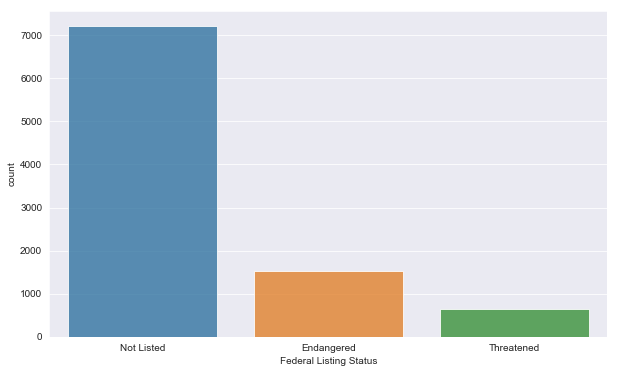

In [8]:
# federal listing status
print(y_train.count())
print('Endangered: ' + str((y_train == 'Endangered').sum() / y_train.count()))
print('Not Listed: ' + str((y_train == 'Not Listed').sum() / y_train.count()))
print('Threatened: ' + str((y_train == 'Threatened').sum() / y_train.count()))

# plot class imbalance
fig, ax = plt.subplots(figsize=(10,6))
sns.countplot(y_train, alpha=0.8)

In [9]:
keys = list(y_train.unique())
values = np.ones((3), dtype=int) * (y_train == 'Not Listed').sum()
sample_ratio = dict(zip(keys, values))
sample_ratio

{'Not Listed': 7211, 'Endangered': 7211, 'Threatened': 7211}

21633
Endangered: 0.3333333333333333
Not Listed: 0.3333333333333333
Threatened: 0.3333333333333333


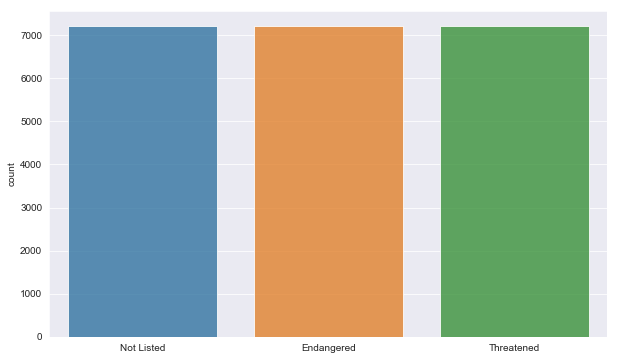

In [10]:
species['Federal Listing Status'].unique()

smote = SMOTE(ratio=sample_ratio)
X_train_smote, y_train_smote = smote.fit_sample(X_train, y_train)

# federal listing status
print(len(y_train_smote))
print('Endangered: ' + str((y_train_smote == 'Endangered').sum() / len(y_train_smote)))
print('Not Listed: ' + str((y_train_smote == 'Not Listed').sum() / len(y_train_smote)))
print('Threatened: ' + str((y_train_smote == 'Threatened').sum() / len(y_train_smote)))

# plot class imbalance
fig, ax = plt.subplots(figsize=(10,6))
sns.countplot(y_train_smote, alpha=0.8)

### Balanced Classification Models

In [11]:
classifiers, metrics = clf.classify(classifiers, X_train_smote, X_test, y_train_smote, y_test)

balanced = pd.DataFrame(metrics, columns=['Model',
                                          'Split',
                                          'Accuracy',
                                          'Precision',
                                          'Recall',
                                          'F1 Score'])

balanced['Configuration'] = 'Balanced'
models = models.append(balanced, ignore_index=True)

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

In [12]:
models.sort_values(by='F1 Score', ascending=False)

,Model,Split,Accuracy,Precision,Recall,F1 Score,Configuration
4,K Nearest Neighbors,Train,0.808393,0.809095,0.808393,0.796395,Baseline
3,Logistic Regression,Test,0.818143,0.790473,0.818143,0.776476,Baseline
9,Random Forest,Test,0.820698,0.822188,0.820698,0.774402,Baseline
5,K Nearest Neighbors,Test,0.783646,0.777395,0.783646,0.773569,Baseline
7,Decision Tree,Test,0.816865,0.750094,0.816865,0.768658,Baseline
15,K Nearest Neighbors,Test,0.767036,0.768467,0.767036,0.763040,Balanced
13,Logistic Regression,Test,0.752555,0.770905,0.752555,0.761037,Balanced
2,Logistic Regression,Train,0.805304,0.772111,0.805304,0.759162,Baseline
8,Random Forest,Train,0.808180,0.786823,0.808180,0.758955,Baseline
6,Decision Tree,Train,0.804772,0.792472,0.804772,0.753474,Baseline


In [13]:
balanced.pivot(index='Model', columns='Split').drop(
    'Configuration', axis=1).sort_values(by=('F1 Score','Train'), ascending=False)

Accuracy           Precision              Recall  \
Split                    Test     Train      Test     Train      Test   
Model                                                                   
K Nearest Neighbors  0.767036  0.709749  0.768467  0.726609  0.767036   
Logistic Regression  0.752555  0.664633  0.770905  0.664243  0.752555   
Random Forest        0.704003  0.598669  0.789379  0.611740  0.704003   
Decision Tree        0.686968  0.593630  0.789761  0.607013  0.686968   
Dummy                0.154600  0.333333  0.023901  0.111111  0.154600   

                               F1 Score            
Split                   Train      Test     Train  
Model                                              
K Nearest Neighbors  0.709749  0.763040  0.704505  
Logistic Regression  0.664633  0.761037  0.658005  
Random Forest        0.598669  0.737356  0.594514  
Decision Tree        0.593630  0.726010  0.590776  
Dummy                0.333333  0.041401  0.166667

### Tuned and Balanced Grid Search Classification Models

In [14]:
# list for all grid searches
grid_searches = []

In [15]:
# logistic regression parameters
parameters_log = dict(penalty=['l1', 'l2'],
                      C=[1e-2, 1e0, 1e2, 1e6, 1e12],
                      fit_intercept=[True, False],
                      multi_class=['ovr'],
                      solver=['liblinear'])

grid_searches.append({'Model': 'Logistic Regression',
                    'Classifier': GridSearchCV(LogisticRegression(),
                                               parameters_log,
                                               cv=5,
                                               scoring='f1_weighted',
                                               verbose=10,
                                               n_jobs=-1)})

# k nearest neighbors parameters
parameters_knn = dict(n_neighbors=[3,5,7],
                      weights=['uniform', 'distance'],
                      algorithm=['ball_tree','kd_tree'],
                      leaf_size=[10,20])

grid_searches.append({'Model': 'K Nearest Neighbors',
                    'Classifier': GridSearchCV(KNeighborsClassifier(),
                                               parameters_knn,
                                               cv=5,
                                               scoring='f1_weighted',
                                               verbose=10,
                                               n_jobs=-1)})

# decision tree parameters
parameters_tree = dict(criterion=['gini','entropy'],
                       max_depth=[2,3,4,5],
                       min_samples_leaf=[10,30,50],
                       max_features=[10,30,50],
                       min_impurity_decrease=[0.01,0.03,0.05])

grid_searches.append({'Model': 'Decision Tree',
                    'Classifier': GridSearchCV(DecisionTreeClassifier(),
                                               parameters_tree,
                                               cv=5,
                                               scoring='f1_weighted',
                                               verbose=10,
                                               n_jobs=-1)})

# random forest parameters
parameters_forest = dict(n_estimators=[100,200,300],
                         max_depth=[2,3,4,5],
                         min_samples_leaf=[10,30,50],
                         max_features=[10,30,50],
                         min_impurity_decrease=[0.01,0.03,0.05])

grid_searches.append({'Model': 'Random Forest',
                    'Classifier': GridSearchCV(RandomForestClassifier(),
                                               parameters_forest,
                                               cv=5,
                                               scoring='f1_weighted',
                                               verbose=10,
                                               n_jobs=-1)})

In [16]:
grid_searches, metrics = clf.grid_search(grid_searches, X_train_smote, X_test, y_train_smote, y_test, X.columns)

tuned = pd.DataFrame(metrics, columns=['Model',
                                       'Split',
                                       'Accuracy',
                                       'Precision',
                                       'Recall',
                                       'F1 Score'])

tuned['Configuration'] = 'Balanced and Tuned'
models = models.append(tuned, ignore_index=True, sort=False)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   56.1s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished


Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 15.2min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 19.5min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 22.3min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 25.6min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 28.6min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 31.7min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 34.4min finished


Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   42.3s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   50.1s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   58.7s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  2

In [17]:
models.sort_values(by='F1 Score', ascending=False)

,Model,Split,Accuracy,Precision,Recall,F1 Score,Configuration
4,K Nearest Neighbors,Train,0.808393,0.809095,0.808393,0.796395,Baseline
3,Logistic Regression,Test,0.818143,0.790473,0.818143,0.776476,Baseline
9,Random Forest,Test,0.820698,0.822188,0.820698,0.774402,Baseline
5,K Nearest Neighbors,Test,0.783646,0.777395,0.783646,0.773569,Baseline
7,Decision Tree,Test,0.816865,0.750094,0.816865,0.768658,Baseline
22,K Nearest Neighbors,Train,0.768040,0.803302,0.768040,0.767889,Balanced and Tuned
15,K Nearest Neighbors,Test,0.767036,0.768467,0.767036,0.763040,Balanced
21,Logistic Regression,Test,0.752555,0.770905,0.752555,0.761037,Balanced and Tuned
13,Logistic Regression,Test,0.752555,0.770905,0.752555,0.761037,Balanced
2,Logistic Regression,Train,0.805304,0.772111,0.805304,0.759162,Baseline


In [18]:
tuned.pivot(index='Model', columns='Split').drop(
    'Configuration', axis=1).sort_values(by=('F1 Score','Train'), ascending=False)

Accuracy           Precision              Recall  \
Split                    Test     Train      Test     Train      Test   
Model                                                                   
K Nearest Neighbors  0.744037  0.768040  0.764747  0.803302  0.744037   
Logistic Regression  0.752555  0.664679  0.770905  0.664271  0.752555   
Random Forest        0.603918  0.577867  0.780704  0.591559  0.603918   
Decision Tree        0.640971  0.571118  0.769705  0.577490  0.640971   

                               F1 Score            
Split                   Train      Test     Train  
Model                                              
K Nearest Neighbors  0.768040  0.746537  0.767889  
Logistic Regression  0.664679  0.761037  0.658053  
Random Forest        0.577867  0.659530  0.575860  
Decision Tree        0.571118  0.686517  0.569039

### Data Loading

In [20]:
models.to_pickle("../Data/models.pkl")
baseline.to_pickle("../Data/baseline.pkl")
balanced.to_pickle("../Data/balanced.pkl")
tuned.to_pickle("../Data/tuned.pkl")

In [23]:
pickle.dump(grid_searches, open( "../Data/grid_searches.pkl", "wb" ))
pickle.dump(metrics, open( "../Data/metrics.pkl", "wb" ))

In [ ]:
metrics[0]['Best Estimator'].